In [2]:
from google import genai
from google.genai import types
import pathlib
import httpx

client = genai.Client()

# Retrieve and encode the PDF byte
file_path = pathlib.Path("data/RAG_25-42.pdf")


# Upload the PDF using the File API
sample_file = client.files.upload(
    file=file_path,
)

prompt = """pdf파일에서 텍스트 내용을 추출해줘. pdf에는 다양한 텍스트와 이미지, 차트가 포함되어 있어.
            텍스트만 추출해줘.
        """

response = client.models.generate_content(
    model="gemini-2.5-pro", contents=[sample_file, prompt]
)
print(response.text)

CHAPTER
01 RAG 이해하기

학습 목표
RAG(Retrieval-Augmented Generation)는 문서 로드, 검색, 답변 생성의 투명한 과정을 통해 할루시네이션 현상을 줄이고, 최신 정보와 신뢰할 수 있는 외부 데이터를 활용해 응답 정확도를 대폭 향상시킴으로써 GPT 모델의 한계를 극복하기 위한 기술입니다. RAG는 프롬프트 엔지니어링이나 파인 튜닝보다 구현이 용이하여 실용적이며, 사용자가 원하는 대로 데이터베이스와 모델을 커스터마이즈할 수 있어 특정 도메인에 특화된 챗봇을 제작할 수 있는 강력한 도구입니다. 그러한 RAG를 사용해야 하는 이유에 관해 알아보겠습니다.

(01) RAG를 사용해야 하는 이유
ChatGPT는 2022년 11월 등장하자마자 순식간에 많은 사용자를 확보했습니다. 2023년 11월에는 GPTs 스토어가 출시되어 GPT의 기능을 플러그인으로 제작하고 배포할 수 있게 되었고, 여러 고급 기능이 보완되면서 사용자들은 단순히 질문하고 답변받는 것에서 더 나아가 전문적인 영역까지 ChatGPT를 적극적으로 활용하기 시작했습니다. 이러한 과정에서 점차 다음과 같은 문제점들이 드러나기 시작했습니다.

1. ChatGPT는 최신 정보가 학습되어 있지 않습니다.
2. 개인이나 회사의 내부 데이터가 학습되어 있지 않아, 특정 도메인(개인 정보, 회사 내부 정보)에 대한 질문에는 기대하는 답변을 얻을 수 없습니다.
3. ChatGPT에 개인이나 회사 정보를 담은 문서를 업로드하면 보안상 문제가 될 수 있습니다.
4. 문서의 양이 많아질수록 할루시네이션 현상이 발생하기 쉽습니다.

ChatGPT의 한계를 보완하기 위해 주목받은 RAG
RAG는 ChatGPT의 한계를 보완하기 위해 주목받기 시작한 기술입니다. RAG란 Retrieval-Augmented Generation의 줄임말로, 검색(Retrieval), 증강(Augmented), 생성(Generation)이라는 의미를 담고 있으며, 거대 언어 모델(LLM; Large Language

## Stuff

In [18]:
from langchain import hub

prompt = hub.pull("teddynote/summary-stuff-documents-korean")
prompt.pretty_print()

Please summarize the sentence according to the following REQUEST.
REQUEST:
1. Summarize the main points in bullet points in KOREAN.
2. Each summarized sentence must start with an emoji that fits the meaning of the each sentence.
3. Use various emojis to make the summary more interesting.
4. Translate the summary into KOREAN if it is written in ENGLISH.
5. DO NOT translate any technical terms.
6. DO NOT include any unnecessary information.

CONTEXT:
{context}

SUMMARY:"



In [59]:
from langchain_openai import ChatOpenAI
from langchain_teddynote.callbacks import StreamingCallback

llm = ChatOpenAI(
    model_name="gpt-4o-mini",
    streaming=True,
    temperature=0,
    callbacks=[StreamingCallback()],
)

In [60]:
from langchain.schema import Document

docs = [Document(page_content=response.text)]

In [61]:
print(len(docs[0].page_content))

12934


In [62]:
from langchain.chains.combine_documents import create_stuff_documents_chain

stuff_chain = create_stuff_documents_chain(llm, prompt)
answer = stuff_chain.invoke({"context": docs})

- 📚 RAG(Retrieval-Augmented Generation)는 GPT 모델의 한계를 극복하기 위한 기술로, 최신 정보와 신뢰할 수 있는 외부 데이터를 활용하여 응답 정확도를 향상시킴.  
- 🔍 RAG는 검색, 증강, 생성의 과정을 통해 할루시네이션 현상을 줄이고, 사용자가 원하는 데이터베이스와 모델을 커스터마이즈할 수 있는 강력한 도구임.  
- ⚙️ RAG는 구현이 용이하여, 사용자가 전문적인 영역에서도 ChatGPT를 활용할 수 있도록 도와줌.  
- 🛡️ RAG를 통해 최신 정보 기반의 답변, 내부 데이터 활용, 문서 저장 및 검증 기능을 제공하여 ChatGPT의 한계를 보완할 수 있음.  
- 🧩 RAG 시스템은 LangChain을 통해 구축할 수 있으며, 다양한 데이터베이스와 연결하여 효율적인 Q&A 시스템을 만들 수 있음.  
- 📈 RAG의 성능은 다양한 기법을 적용함에 따라 점진적으로 향상되며, 최종적으로 높은 정확도를 달성할 수 있음.

## Map-Reduce



### MAP

In [63]:
from langchain import hub
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

llm = ChatOpenAI(
    temperature=0,
    model_name="gpt-4o-mini",
)

map_prompt = hub.pull("teddynote/map-prompt")

map_prompt.pretty_print()

================================ System Message ================================

You are a professional main thesis extractor.

================================ Human Message =================================

Your task is to extract main thesis from given documents. Answer should be in same language as given document. 

#Format: 
- thesis 1
- thesis 2
- thesis 3
- ...

Here is a given document: 
{doc}

Write 1~5 sentences.
#Answer:


In [64]:
map_chain = map_prompt | llm | StrOutputParser()

docs를 스플릿해서 부분 요약할 수 있게 나눔

In [66]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document

splitter = RecursiveCharacterTextSplitter(
    chunk_size=3000,
    chunk_overlap=200,   # 필요시 오버랩 조금 두기
    separators=["\n\n", "\n", " ", ""]
)

chunks = splitter.split_text(docs[0].page_content)
docs = [Document(page_content=c) for c in chunks]

print("생성된 청크 개수:", len(docs))
for i, d in enumerate(docs):
    print(f"청크 {i} 길이:", len(d.page_content))


생성된 청크 개수: 5
청크 0 길이: 2754
청크 1 길이: 2595
청크 2 길이: 2777
청크 3 길이: 2736
청크 4 길이: 2242


In [78]:
print(len(docs))

5


In [67]:
doc_summaries = map_chain.batch(docs)

In [68]:
len(doc_summaries)

5

In [71]:
for doc in doc_summaries:
    print(doc)
    print("="*50)

- RAG(Retrieval-Augmented Generation)는 GPT 모델의 한계를 극복하고 응답 정확도를 향상시키기 위한 기술로, 최신 정보와 신뢰할 수 있는 외부 데이터를 활용한다.
- RAG는 ChatGPT의 최신 정보 부족, 내부 데이터 미학습, 보안 문제, 할루시네이션 현상 등의 문제를 해결할 수 있는 방법론이다.
- RAG를 통해 사용자는 개인 맞춤형 챗봇이나 특정 도메인에 최적화된 챗봇을 자유롭게 생성할 수 있다.
- RAG는 GPT가 사전 학습된 지식에 의존하지 않고, 제공된 자료를 바탕으로 더 정확한 답변을 생성할 수 있도록 돕는다.
- ChatGPT의 내장 RAG 시스템은 사용자가 문서를 업로드하고 질문할 때 그럴듯한 답변을 제공하지만, 그 정보의 정확성을 확인하기는 어렵다.
- 한국개발연구원(KDI)에서 발간한 2023년 하반기 경제전망 보고서는 국내외 경제 동향을 분석하고 중단기 경제 전망을 제공하여 정부와 기업의 정책 수립에 도움을 주기 위해 작성되었다.
- 보고서는 고금리 기조, 수출 회복세, 내수 둔화 등 현재의 경제 상황과 2024년의 완만한 경제 회복 전망을 다룬다.
- 또한, 국제유가 변동과 중국 경제 상황 변화 등 대외 불확실성을 위험 요인으로 지적하며 이에 대한 대응 방안을 모색한다.
- ChatGPT는 문서의 구체적인 내용을 제공하지 못하는 경우가 발생하며, 이는 사용자가 질문을 구체화할수록 할루시네이션이 발생할 수 있음을 보여준다.
- RAG 시스템은 최신 정보를 기반으로 답변을 제공하고, 그 과정의 투명성을 높여 사용자가 답변의 정확성을 확인할 수 있도록 돕는다.
- LangSmith와 RAG 시스템을 통해 LLM의 답변 추적 과정을 심도 있게 분석하고 개선할 수 있다.
- RAG는 LLM의 할루시네이션을 감소시키는 데 효과적이며, 유효한 정보만을 기반으로 답변을 도출하도록 돕는다.
- LangChain은 대규모 언어 모델을 활용한 애플리케이션 개발을 용이하게 하며, 다양한 서비스에 GPT를 접목할 수 있는 도구

### Reduce

In [72]:
# reduce prompt 다운로드
reduce_prompt = hub.pull("teddynote/reduce-prompt")

# 프롬프트 출력
reduce_prompt.pretty_print()

================================ System Message ================================

You are a professional summarizer. You are given a list of summaries of documents and you are asked to create a single summary of the documents.

================================ Human Message =================================

#Instructions: 
1. Extract main points from a list of summaries of documents
2. Make final summaries in bullet points format.
3. Answer should be written in {language}.

#Format: 
- summary 1
- summary 2
- summary 3
- ...

Here is a list of summaries of documents: 
{doc_summaries}

#SUMMARY:


In [73]:
reduce_chain = reduce_prompt | llm | StrOutputParser()

부분요약을 모아서 전체요약으로 요약

In [74]:
from langchain_teddynote.messages import stream_response

answer = reduce_chain.stream(
    {"doc_summaries": "\n".join(doc_summaries), "language": "Korean"}
)
stream_response(answer)

- RAG(Retrieval-Augmented Generation)는 GPT 모델의 한계를 극복하고 응답 정확도를 향상시키기 위한 기술로, 최신 정보와 신뢰할 수 있는 외부 데이터를 활용한다.
- RAG는 ChatGPT의 최신 정보 부족, 내부 데이터 미학습, 보안 문제, 할루시네이션 현상 등의 문제를 해결할 수 있는 방법론이다.
- 사용자는 RAG를 통해 개인 맞춤형 챗봇이나 특정 도메인에 최적화된 챗봇을 생성할 수 있다.
- RAG는 GPT가 사전 학습된 지식에 의존하지 않고, 제공된 자료를 바탕으로 더 정확한 답변을 생성하도록 돕는다.
- 한국개발연구원(KDI)의 경제전망 보고서는 고금리 기조, 수출 회복세, 내수 둔화 등 현재의 경제 상황과 2024년의 완만한 경제 회복 전망을 다룬다.
- RAG 시스템은 최신 정보를 기반으로 답변을 제공하고, 그 과정의 투명성을 높여 사용자가 답변의 정확성을 확인할 수 있도록 돕는다.
- LangChain은 대규모 언어 모델을 활용한 애플리케이션 개발을 용이하게 하며, RAG 프로세스를 통해 비즈니스 환경에서도 활용 가능한 성능을 달성할 수 있다.
- RAG 프로세스는 사용자의 질문에 대해 관련 정보를 데이터베이스에서 검색하여 LLM이 보다 정확한 답변을 생성하도록 돕는 구조로 되어 있다.
- RAG의 실행 단계는 질문에 맞는 벡터를 검색하고, 이를 바탕으로 언어 모델이 답변을 생성하는 일련의 과정을 포함한다.
- RAG를 활용한 프롬프트 최적화와 파인 튜닝을 통해 모델의 성능을 극대화할 수 있다.

하나의 체인에 묶어서 실행하기

In [79]:
from langchain_core.runnables import chain


@chain
def map_reduce_chain(docs):
    map_llm = ChatOpenAI(
        temperature=0,
        model_name="gpt-4o-mini",
    )

    # map prompt 다운로드
    map_prompt = hub.pull("teddynote/map-prompt")

    # map chain 생성
    map_chain = map_prompt | map_llm | StrOutputParser()

    # 첫 번째 프롬프트, ChatOpenAI, 문자열 출력 파서를 연결하여 체인을 생성합니다.
    doc_summaries = map_chain.batch(docs)

    # reduce prompt 다운로드
    reduce_prompt = hub.pull("teddynote/reduce-prompt")
    reduce_llm = ChatOpenAI(
        model_name="gpt-4o",
        temperature=0,
        callbacks=[StreamingCallback()],
        streaming=True,
    )

    reduce_chain = reduce_prompt | reduce_llm | StrOutputParser()

    return reduce_chain.invoke(
        {"doc_summaries": "\n".join(doc_summaries), "language": "Korean"}
    )

In [80]:
answer = map_reduce_chain.invoke(docs)

- RAG(Retrieval-Augmented Generation)는 GPT 모델의 한계를 극복하고 응답 정확도를 향상시키기 위한 기술로, 최신 정보와 신뢰할 수 있는 외부 데이터를 활용한다.
- RAG는 ChatGPT의 최신 정보 부족, 내부 데이터 미비, 보안 문제, 할루시네이션 현상 등의 문제를 해결할 수 있는 방법론이다.
- RAG를 통해 사용자는 개인 맞춤형 챗봇이나 특정 도메인에 최적화된 챗봇을 생성할 수 있으며, GPT가 사전 학습된 지식에 의존하지 않고 더 정확한 답변을 생성할 수 있도록 돕는다.
- RAG 시스템은 최신 정보를 기반으로 답변을 제공하고, 그 과정의 투명성을 높여 사용자가 답변의 정확성을 확인할 수 있도록 돕는다.
- LangSmith와 RAG 시스템을 통해 LLM의 답변 추적 과정을 심도 있게 분석하고 개선할 수 있으며, RAG는 LLM의 할루시네이션을 감소시키는 데 효과적이다.
- LangChain은 대규모 언어 모델을 활용한 애플리케이션 개발을 용이하게 하며, 다양한 서비스에 GPT를 접목할 수 있는 도구이다.
- RAG 프로세스는 사용자의 질문에 대해 관련 정보를 데이터베이스에서 검색하여 LLM이 보다 정확한 답변을 생성하도록 돕는 구조로 되어 있다.
- 데이터 소스를 벡터 스토어로 사용하여 문서 로드, 텍스트 분할, 임베딩, 저장의 네 단계를 통해 정보를 처리하는 과정이 설명된다.
- RAG를 활용한 프롬프트 최적화와 파인 튜닝을 통해 모델의 성능을 극대화하고, 정확도를 98%까지 향상시킬 수 있다.
- 한국개발연구원(KDI)의 2023년 하반기 경제전망 보고서는 국내외 경제 동향을 분석하고 중단기 경제 전망을 제공하여 정부와 기업의 정책 수립에 도움을 주기 위해 작성되었다.
- 보고서는 고금리 기조, 수출 회복세, 내수 둔화 등 현재의 경제 상황과 2024년의 완만한 경제 회복 전망을 다루며, 국제유가 변동과 중국 경제 상황 변화 등 대외 불확실성을 위험 요인으로 지적한다.

## Map-Refine

청크로 나눈 후 첫번째 청크를 요약 -> 요약된 문장과 두번째 청크를 합쳐서 요약 -> 요약된 문장과 세번재 청크를 합쳐서 요약 -> ...

### Map

In [81]:
from langchain import hub
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

# map llm 생성
map_llm = ChatOpenAI(
    temperature=0,
    model_name="gpt-4o-mini",
)

# map chain 생성
map_summary = hub.pull("teddynote/map-summary-prompt")

# 프롬프트 출력
map_summary.pretty_print()

================================ System Message ================================

You are an expert summarizer. Your task is to summarize the following document in {language}.

================================ Human Message =================================

Extract most important main thesis from the documents, then summarize in bullet points.

#Format:
- summary 1
- summary 2
- summary 3
-...

Here is a given document: 
{documents}

Write 1~5 sentences. Think step by step.
#Summary:


In [82]:
# map chain 생성
map_chain = map_summary | llm | StrOutputParser()

In [83]:
# 첫 번째 문서의 요약 출력
print(map_chain.invoke({"documents": docs[0], "language": "Korean"}))

- RAG(Retrieval-Augmented Generation)는 GPT 모델의 한계를 극복하기 위해 최신 정보와 신뢰할 수 있는 외부 데이터를 활용하여 응답 정확도를 향상시키는 기술이다.
- RAG는 사용자가 원하는 대로 데이터베이스와 모델을 커스터마이즈할 수 있어 특정 도메인에 특화된 챗봇 제작에 유용하다.
- RAG를 통해 최신 정보 기반의 답변 제공, 내부 데이터 활용, 할루시네이션 현상 감소 등의 문제를 해결할 수 있다.
- RAG는 GPT에 정보 검색 기능을 추가하여 사전 학습된 지식에 의존하지 않고 정확한 답변을 생성할 수 있도록 한다.
- ChatGPT의 내장 RAG 시스템은 사용자가 문서를 업로드하고 질문할 때 그럴듯한 답변을 제공하지만, 정보의 정확성을 확인하기 어려운 단점이 있다.


In [84]:
# 모든 문서를 입력으로 정의합니다.
input_doc = [{"documents": doc, "language": "Korean"} for doc in docs]

In [85]:
input_doc

[{'documents': Document(metadata={}, page_content='CHAPTER\n01 RAG 이해하기\n\n학습 목표\nRAG(Retrieval-Augmented Generation)는 문서 로드, 검색, 답변 생성의 투명한 과정을 통해 할루시네이션 현상을 줄이고, 최신 정보와 신뢰할 수 있는 외부 데이터를 활용해 응답 정확도를 대폭 향상시킴으로써 GPT 모델의 한계를 극복하기 위한 기술입니다. RAG는 프롬프트 엔지니어링이나 파인 튜닝보다 구현이 용이하여 실용적이며, 사용자가 원하는 대로 데이터베이스와 모델을 커스터마이즈할 수 있어 특정 도메인에 특화된 챗봇을 제작할 수 있는 강력한 도구입니다. 그러한 RAG를 사용해야 하는 이유에 관해 알아보겠습니다.\n\n(01) RAG를 사용해야 하는 이유\nChatGPT는 2022년 11월 등장하자마자 순식간에 많은 사용자를 확보했습니다. 2023년 11월에는 GPTs 스토어가 출시되어 GPT의 기능을 플러그인으로 제작하고 배포할 수 있게 되었고, 여러 고급 기능이 보완되면서 사용자들은 단순히 질문하고 답변받는 것에서 더 나아가 전문적인 영역까지 ChatGPT를 적극적으로 활용하기 시작했습니다. 이러한 과정에서 점차 다음과 같은 문제점들이 드러나기 시작했습니다.\n\n1. ChatGPT는 최신 정보가 학습되어 있지 않습니다.\n2. 개인이나 회사의 내부 데이터가 학습되어 있지 않아, 특정 도메인(개인 정보, 회사 내부 정보)에 대한 질문에는 기대하는 답변을 얻을 수 없습니다.\n3. ChatGPT에 개인이나 회사 정보를 담은 문서를 업로드하면 보안상 문제가 될 수 있습니다.\n4. 문서의 양이 많아질수록 할루시네이션 현상이 발생하기 쉽습니다.\n\nChatGPT의 한계를 보완하기 위해 주목받은 RAG\nRAG는 ChatGPT의 한계를 보완하기 위해 주목받기 시작한 기술입니다. RAG란 Retrieval-Augmented Generation의 줄임말로, 검색(Retrieval), 증강(Augm

In [86]:
# 모든 문서에 대한 요약본을 출력합니다.
print(map_chain.batch(input_doc))

['- RAG(Retrieval-Augmented Generation)는 GPT 모델의 한계를 극복하기 위해 최신 정보와 신뢰할 수 있는 외부 데이터를 활용하여 응답 정확도를 향상시키는 기술이다.\n- RAG는 ChatGPT의 최신 정보 부족, 내부 데이터 미반영, 보안 문제, 할루시네이션 현상 등의 문제를 해결할 수 있다.\n- RAG를 통해 사용자는 개인 맞춤형 챗봇이나 특정 도메인에 최적화된 챗봇을 쉽게 생성할 수 있으며, 데이터베이스를 업데이트함으로써 최신 정보를 반영한 답변을 얻을 수 있다.\n- RAG는 GPT가 사전 학습된 지식에 의존하지 않고 제공된 자료를 기반으로 정확한 답변을 생성할 수 있도록 돕는다.\n- ChatGPT의 내장 RAG 시스템은 사용자가 문서를 업로드하고 질문할 때 그럴듯한 답변을 제공하지만, 이 정보의 정확성을 확인하기는 어렵다.', '- 한국개발연구원(KDI)의 2023년 하반기 경제전망 보고서는 국내외 경제 동향과 중단기 경제 전망을 분석하여 정부와 기업의 정책 수립에 도움을 주기 위해 작성되었다.\n- 보고서는 고금리, 수출 회복, 내수 둔화 등 현재 경제 상황을 다루며, 2024년 경제 전망으로 완만한 회복세를 예측하고 다양한 경제 지표를 제시한다.\n- 정책 방향으로는 재정정책, 통화정책, 금융정책을 제안하며, 대외 불확실성 요인에 대한 대응 방안을 모색한다.\n- ChatGPT는 문서의 구체적인 데이터를 제공하지 못하는 경우가 있으며, 사용자가 문서 내용을 효과적으로 검색할 수 있도록 형식을 변경하는 것이 필요하다.\n- RAG 기술은 최신 정보를 기반으로 답변을 제공하고, 답변 과정을 투명하게 모니터링할 수 있는 장점을 가지고 있다.', '- LangSmith 도구를 사용하여 LLM의 답변 추적 과정을 분석하고, 답변의 출처와 관련 문서를 확인할 수 있다.\n- RAG 시스템은 LLM의 할루시네이션을 줄이는 데 효과적이며, 유효한 정보에 기반한 답변을 제공하도록 돕는다.\n- LangChain은 대규모 언어 모델

### Refine

In [87]:
# refine prompt 다운로드
refine_prompt = hub.pull("teddynote/refine-prompt")

# 프롬프트 출력
refine_prompt.pretty_print()

================================ System Message ================================

You are an expert summarizer.

================================ Human Message =================================

Your job is to produce a final summary

We have provided an existing summary up to a certain point:
{previous_summary}

We have the opportunity to refine the existing summary(only if needed) with some more context below.
------------
{current_summary}
------------
Given the new context, refine the original summary in {language}.
If the context isn't useful, return the original summary.


In [88]:
# refine llm 생성
refine_llm = ChatOpenAI(
    temperature=0,
    model_name="gpt-4o-mini",
)

# refine chain 생성
refine_chain = refine_prompt | refine_llm | StrOutputParser()

In [89]:
from langchain_core.runnables import chain


@chain
def map_refine_chain(docs):

    # map chain 생성
    map_summary = hub.pull("teddynote/map-summary-prompt")

    map_chain = (
        map_summary
        | ChatOpenAI(
            model_name="gpt-4o-mini",
            temperature=0,
        )
        | StrOutputParser()
    )

    input_doc = [{"documents": doc.page_content, "language": "Korean"} for doc in docs]

    # 첫 번째 프롬프트, ChatOpenAI, 문자열 출력 파서를 연결하여 체인을 생성합니다.
    doc_summaries = map_chain.batch(input_doc)

    refine_prompt = hub.pull("teddynote/refine-prompt")

    refine_llm = ChatOpenAI(
        model_name="gpt-4o-mini",
        temperature=0,
        callbacks=[StreamingCallback()],
        streaming=True,
    )

    refine_chain = refine_prompt | refine_llm | StrOutputParser()

    previous_summary = doc_summaries[0]

    for current_summary in doc_summaries[1:]:

        previous_summary = refine_chain.invoke(
            {
                "previous_summary": previous_summary,
                "current_summary": current_summary,
                "language": "Korean",
            }
        )
        print("\n\n-----------------\n\n")

    return previous_summary

In [90]:
refined_summary = map_refine_chain.invoke(docs)

- RAG(Retrieval-Augmented Generation)는 GPT 모델의 한계를 극복하기 위해 최신 정보와 신뢰할 수 있는 외부 데이터를 활용하여 응답 정확도를 향상시키는 기술이다.
- RAG는 사용자가 원하는 대로 데이터베이스와 모델을 커스터마이즈할 수 있어 특정 도메인에 특화된 챗봇 제작이 가능하다.
- ChatGPT는 최신 정보 부족, 내부 데이터 미학습, 보안 문제, 할루시네이션 현상 등의 한계를 가지고 있으며, RAG는 이러한 문제를 해결할 수 있다.
- RAG를 통해 최신 정보를 기반으로 답변하고, 내부 데이터베이스를 활용하여 개인 맞춤형 응답을 제공할 수 있다.
- RAG 시스템을 고도화하면 답변의 정교함이 높아지고, 효율적인 정보 검색이 가능해진다.
- 한국개발연구원(KDI)의 2023년 하반기 경제전망 보고서는 고금리, 수출 회복, 내수 둔화, 물가 상황 등을 분석하여 2024년 경제 전망을 제시하며, 재정정책, 통화정책, 금융정책 등의 방향을 제안한다. 
- RAG 시스템은 이러한 최신 경제 정보를 기반으로 질문에 대한 답변을 제공할 수 있으며, 구현 난이도가 낮아 개인이 쉽게 시도할 수 있는 수준이다.

-----------------


- RAG(Retrieval-Augmented Generation)는 GPT 모델의 한계를 극복하기 위해 최신 정보와 신뢰할 수 있는 외부 데이터를 활용하여 응답 정확도를 향상시키는 기술이다.
- RAG는 사용자가 원하는 대로 데이터베이스와 모델을 커스터마이즈할 수 있어 특정 도메인에 특화된 챗봇 제작이 가능하다.
- ChatGPT는 최신 정보 부족, 내부 데이터 미학습, 보안 문제, 할루시네이션 현상 등의 한계를 가지고 있으며, RAG는 이러한 문제를 해결할 수 있다.
- RAG를 통해 최신 정보를 기반으로 답변하고, 내부 데이터베이스를 활용하여 개인 맞춤형 응답을 제공할 수 있다.
- RAG 시스템을 고도화하면 답변의 정교함이 높아지고, 효율적인 정보 검색이 가능해진다.
- LangChain

## Chain of Density

초기 요약 생성 -> 길이는 그대로 두면서 누락된 중요 개체들을 반복적으로 통합 -> 반복 -> 짧은 요약이지만 핵심 정보를 포함한 요약으로 수렴됨

In [91]:
# Chain of Density 프롬프트 다운로드
cod_prompt = hub.pull("teddynote/chain-of-density-prompt")

cod_prompt.pretty_print()

================================ System Message ================================

As an expert copy-writer, you will write increasingly concise, entity-dense summaries of the user provided {content_category}. The initial summary should be under {max_words} words and contain {entity_range} informative Descriptive Entities from the {content_category}.

A Descriptive Entity is:
- Relevant: to the main story.
- Specific: descriptive yet concise (5 words or fewer).
- Faithful: present in the {content_category}.
- Anywhere: located anywhere in the {content_category}.

# Your Summarization Process
- Read through the {content_category} and the all the below sections to get an understanding of the task.
- Pick {entity_range} informative Descriptive Entities from the {content_category} (";" delimited, do not add spaces).
- In your output JSON list of dictionaries, write an initial summary of max {max_words} words containing the Entities.
- You now have `[{"missing_entities": "...", "denser_summa

In [92]:
import textwrap
from langchain import hub
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import SimpleJsonOutputParser

# {content}를 제외한 모든 입력에 대한 기본값 지정
cod_chain_inputs = {
    "content": lambda d: d.get("content"),
    "content_category": lambda d: d.get("content_category", "Research/Technical Book"),
    "entity_range": lambda d: d.get("entity_range", "3-5"),
    "max_words": lambda d: int(d.get("max_words", 120)),
    "iterations": lambda d: int(d.get("iterations", 5)),
}

# Chain of Density 프롬프트 다운로드
cod_prompt = hub.pull("teddynote/chain-of-density-prompt")

# Chain of Density 체인 생성
cod_chain = (
    cod_chain_inputs
    | cod_prompt
    | ChatOpenAI(temperature=0, model="gpt-4o-mini")
    | SimpleJsonOutputParser()
)

# 두 번째 체인 생성, 최종 요약만 추출 (스트리밍 불가능, 최종 결과가 필요함)
cod_final_summary_chain = cod_chain | (
    lambda output: output[-1].get(
        "denser_summary", '오류: 마지막 딕셔너리에 "denser_summary" 키가 없습니다'
    )
)

In [94]:
# 결과를 저장할 빈 리스트 초기화
results: list[dict[str, str]] = []

# cod_chain을 스트리밍 모드로 실행하고 부분적인 JSON 결과를 처리
for partial_json in cod_chain.stream(
    {"content": doc, "content_category": "Research/Technical Book"}
):
    # 각 반복마다 results를 업데이트
    results = partial_json

    # 현재 결과를 같은 줄에 출력 (캐리지 리턴을 사용하여 이전 출력을 덮어씀)
    print(results, end="\r", flush=True)

# 총 요약 수 계산
total_summaries = len(results)
print("\n")

# 각 요약을 순회하며 처리
i = 1
for cod in results:
    # 누락된 엔티티들을 추출하고 포맷팅
    added_entities = ", ".join(
        [
            ent.strip()
            for ent in cod.get(
                "missing_entities", 'ERR: "missing_entiies" key not found'
            ).split(";")
        ]
    )
    # 더 밀도 있는 요약 추출
    summary = cod.get("denser_summary", 'ERR: missing key "denser_summary"')

    # 요약 정보 출력 (번호, 총 개수, 추가된 엔티티)
    print(
        f"### CoD Summary {i}/{total_summaries}, 추가된 엔티티(entity): {added_entities}"
        + "\n"
    )
    # 요약 내용을 80자 너비로 줄바꿈하여 출력
    print(textwrap.fill(summary, width=80) + "\n")
    i += 1

print("\n============== [최종 요약] =================\n")
print(summary)

[{'missing_entities': '리트리버 단계;프롬프트 단계;LLM 단계;체인 생성 단계;RAG 파이프라인', 'denser_summary': '이 연구에서는 리트리버 단계, 프롬프트 단계, LLM 단계, 체인 생성 단계, RAG 파이프라인을 통해 사용자 질문을 처리하는 방법을 설명한다. 리트리버 단계는 질문을 벡터로 변환하여 관련 문서를 검색하는 과정이다. 프롬프트 단계에서는 검색된 문서를 바탕으로 언어 모델이 사용할 질문이나 명령을 생성한다. LLM 단계는 구성된 프롬프트를 입력으로 받아 대규모 언어 모델을 통해 응답을 생성한다. 마지막으로, 체인 생성 단계는 이 모든 단계를 통합하여 완전한 RAG 파이프라인을 조립한다.'}, {'missing_entities': '프롬프트 최적화;파인 튜닝', 'denser_summary': '이 연구에서는 리트리버 단계, 프롬프트 단계, LLM 단계, 체인 생성 단계, RAG 파이프라인을 통해 사용자 질문을 처리하는 방법을 설명한다. 리트리버 단계는 질문을 벡터로 변환하여 관련 문서를 검색하는 과정이다. 프롬프트 단계에서는 검색된 문서를 바탕으로 언어 모델이 사용할 질문이나 명령을 생성한다. LLM 단계는 구성된 프롬프트를 입력으로 받아 대규모 언어 모델을 통해 응답을 생성한다. 마지막으로, 체인 생성 단계는 이 모든 단계를 통합하여 완전한 RAG 파이프라인을 조립하며, 프롬프트 최적화와 파인 튜닝을 통해 모델 성능을 극대화할 수 있다.'}, {'missing_entities': '사용자 질문;대규모 언어 모델', 'denser_summary': '이 연구에서는 리트리버 단계, 프롬프트 단계, LLM 단계, 체인 생성 단계, RAG 파이프라인을 통해 사용자 질문을 처리하는 방법을 설명한다. 리트리버 단계는 사용자 질문을 벡터로 변환하여 관련 문서를 검색하는 과정이다. 프롬프트 단계에서는 검색된 문서를 바탕으로 언어 모델이 사용할 질문이나 명령을 생성한다. LLM 단계는 구성된 프롬프트를 입력으로 받아 대규모 언

In [95]:
print(summary)

이 연구에서는 리트리버 단계, 프롬프트 단계, LLM 단계, 체인 생성 단계, RAG 파이프라인을 통해 사용자 질문을 처리하는 방법을 설명한다. 리트리버 단계는 사용자 질문을 벡터로 변환하여 관련 문서를 검색하는 과정이다. 프롬프트 단계에서는 검색된 문서를 바탕으로 언어 모델이 사용할 질문이나 명령을 생성한다. LLM 단계는 구성된 프롬프트를 입력으로 받아 대규모 언어 모델을 통해 사용자 질문에 대한 응답을 생성한다. 마지막으로, 체인 생성 단계는 이 모든 단계를 통합하여 완전한 RAG 파이프라인을 조립하며, 프롬프트 최적화와 파인 튜닝을 통해 모델 성능을 극대화한다.


## Clustering-Map-Refine

기존 Map-Refine기법도 좋은 방법이지만 더 나아가 비슷한 청크끼리 묶어서 각 클러스터 중심에 가까운 텍스트만 요약하고 Refine 방식으로 보강하는 방식

즉 비슷한 내용은 모아서 요약하고 그 요약을 점진적으로 보강하는 방식

In [96]:
# 하나의 Text 로 모든 문서를 연결합니다.
texts = "\n\n".join([doc.page_content for doc in docs])
len(texts)

13112

In [97]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
split_docs = text_splitter.split_text(texts)

In [98]:
len(split_docs)

36

In [100]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings()

vectors = embeddings.embed_documents(split_docs)

In [101]:
from sklearn.cluster import KMeans

# 클러스터 수를 선택하면 문서의 콘텐츠에 따라 조정할 수 있습니다.
num_clusters = 10

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=123).fit(vectors)

In [102]:
# 결과 확인
kmeans.labels_

array([4, 4, 4, 9, 9, 9, 1, 5, 5, 1, 1, 4, 4, 9, 7, 2, 4, 2, 2, 9, 9, 6,
       6, 8, 0, 0, 0, 6, 3, 7, 7, 3, 3, 7, 4, 4])

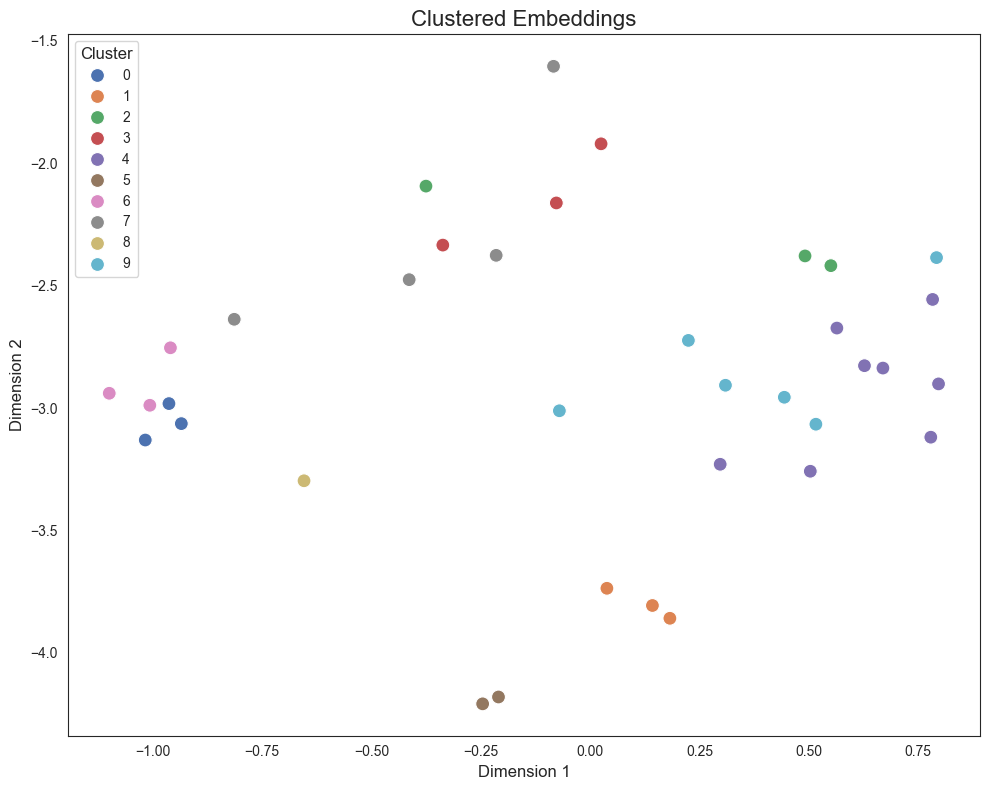

In [103]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 경고 제거
import warnings

warnings.filterwarnings("ignore")

# t-SNE 수행 및 2차원으로 축소
tsne = TSNE(n_components=2, random_state=42)
reduced_data_tsne = tsne.fit_transform(np.array(vectors))

# seaborn 스타일 설정
sns.set_style("white")

# 축소된 데이터 플롯
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=reduced_data_tsne[:, 0],
    y=reduced_data_tsne[:, 1],
    hue=kmeans.labels_,
    palette="deep",
    s=100,
)
plt.xlabel("Dimension 1", fontsize=12)
plt.ylabel("Dimension 2", fontsize=12)
plt.title("Clustered Embeddings", fontsize=16)
plt.legend(title="Cluster", title_fontsize=12)

# 배경색 설정
plt.gcf().patch.set_facecolor("white")

plt.tight_layout()
plt.show()

In [104]:
import numpy as np

# 가장 가까운 점들을 저장할 빈 리스트 생성
closest_indices = []

# 클러스터 수만큼 반복
for i in range(num_clusters):

    # 해당 클러스터 중심으로부터의 거리 목록 구하기
    distances = np.linalg.norm(vectors - kmeans.cluster_centers_[i], axis=1)

    # 가장 가까운 점의 인덱스 찾기 (argmin을 사용하여 최소 거리 찾기)
    closest_index = np.argmin(distances)

    # 해당 인덱스를 가장 가까운 인덱스 리스트에 추가
    closest_indices.append(closest_index)

In [105]:
closest_indices

[24, 9, 18, 28, 2, 8, 22, 14, 23, 19]

In [106]:
# 문서의 요약을 순서대로 진행하기 위하여 오름차순 정렬
selected_indices = sorted(closest_indices)
selected_indices

[2, 8, 9, 14, 18, 19, 22, 23, 24, 28]

In [107]:
from langchain_core.documents import Document

selected_docs = [Document(page_content=split_docs[doc]) for doc in selected_indices]
selected_docs

[Document(metadata={}, page_content='ChatGPT의 한계를 보완하기 위해 주목받은 RAG\nRAG는 ChatGPT의 한계를 보완하기 위해 주목받기 시작한 기술입니다. RAG란 Retrieval-Augmented Generation의 줄임말로, 검색(Retrieval), 증강(Augmented), 생성(Generation)이라는 의미를 담고 있으며, 거대 언어 모델(LLM; Large Language Model)이 외부의 신뢰할 수 있는 지식 데이터베이스를 참조하여 최적화된 응답을 생성하는 기술입니다.\n\nRAG의 다양한 방법론을 활용하여 지속적으로 업그레이드하면 ChatGPT만 사용했을 때 50점 수준이었던 답변의 품질을 80점, 90점대로 끌어올릴 수 있습니다. 적절한 RAG를 적용하면 앞서 언급된 문제점들을 다음과 같이 개선할 수 있습니다.'),
 Document(metadata={}, page_content='4. 위험 요인으로는 국제유가 변동, 중국의 경제 상황 변화 등 대외 불확실성이 높은 점을 지적하며, 이에 대한 대응 방안을 모색합니다.\n이 보고서는 정부 및 기업의 정책 결정에 중요한 정보를 제공하며, 경제 상황에 대한 깊은 이해와 미래 전망에 대한 지침을 담고 있습니다.'),
 Document(metadata={}, page_content='문서 내용에 대해 더 자세히 알아보고자 세부 내용을 선택하여 다시 질문하고, 반드시 문서의 내용을 바탕으로 답변해 달라고 요청했습니다. 그러나 ChatGPT는 해당 내용에 대한 구체적인 데이터를 제공하지 않는다는 이상한 답변을 내놓았습니다. 문서에 분명히 해당 내용이 있음에 도 ChatGPT가 관련 정보를 찾지 못하는 현상이 발생했습니다.\n보고서에서는 유로존의 전체 및 청년 실업률에 대한 구체적인 데이터를 제공하지 않습니다. 이 문서는 한국의 경제 상황과 전망에 초점을 맞추고 있어, 유로존의 실업률과 같은 특정 국제 경제 지표에 대한 세부 수치는 포함되어 있지 않습니다. 유

In [108]:
# 이전에 생성한 map_refine_chain을 사용하여 요약 생성
refined_summary = map_refine_chain.invoke(selected_docs)

원래 요약을 다음과 같이 수정합니다:

- RAG(검색 증강 생성)는 ChatGPT의 한계를 보완하기 위해 개발된 기술이다.
- RAG는 거대 언어 모델이 외부의 신뢰할 수 있는 데이터베이스를 참조하여 응답을 생성하는 방식이다.
- RAG를 활용하면 ChatGPT의 답변 품질을 50점에서 80점, 90점으로 향상시킬 수 있다.
- 적절한 RAG 적용을 통해 ChatGPT의 문제점을 개선할 수 있다.
- 또한, 국제유가 변동과 중국 경제 상황 변화가 주요 위험 요인으로 지적되며, 대외 불확실성에 대한 대응 방안을 모색하고 있다. 이 보고서는 정부 및 기업의 정책 결정에 중요한 정보를 제공하고, 경제 상황에 대한 깊은 이해와 미래 전망에 대한 지침을 포함하고 있다.

-----------------


- RAG(검색 증강 생성)는 ChatGPT의 한계를 보완하기 위해 개발된 기술이다.
- RAG는 거대 언어 모델이 외부의 신뢰할 수 있는 데이터베이스를 참조하여 응답을 생성하는 방식이다.
- RAG를 활용하면 ChatGPT의 답변 품질을 50점에서 80점, 90점으로 향상시킬 수 있다.
- 적절한 RAG 적용을 통해 ChatGPT의 문제점을 개선할 수 있다.
- 문서에서는 한국의 경제 상황과 전망에 중점을 두고 있으며, 국제유가 변동과 중국 경제 상황 변화가 주요 위험 요인으로 지적된다. 대외 불확실성에 대한 대응 방안을 모색하고 있으며, 이 보고서는 정부 및 기업의 정책 결정에 중요한 정보를 제공하고, 경제 상황에 대한 깊은 이해와 미래 전망에 대한 지침을 포함하고 있다.
- 유로존의 실업률에 대한 구체적인 데이터는 제공되지 않으며, 해당 정보는 유럽연합 통계국(Eurostat) 웹사이트에서 확인할 수 있다.

-----------------


- RAG(검색 증강 생성)는 ChatGPT의 한계를 보완하기 위해 개발된 기술이다.
- RAG는 거대 언어 모델이 외부의 신뢰할 수 있는 데이터베이스를 참조하여 응답을 생성하는 방식이다.
- RAG를 활용하면 Chat

In [109]:
# 최종 결과 출력
print(refined_summary)

- RAG(검색 증강 생성)는 ChatGPT의 한계를 보완하기 위해 개발된 기술이다.
- RAG는 거대 언어 모델이 외부의 신뢰할 수 있는 데이터베이스를 참조하여 응답을 생성하는 방식이다.
- RAG를 활용하면 ChatGPT의 답변 품질을 50점에서 80점, 90점으로 향상시킬 수 있다.
- 적절한 RAG 적용을 통해 ChatGPT의 문제점을 개선할 수 있다.
- RAG 프로세스는 GPT와 같은 LLM이 질문에 답변할 때 참고할 정보를 미리 저장하는 방법이다.
- 사용자가 질문을 입력하면, RAG는 관련 문서를 데이터베이스에서 찾아 LLM에 제공하여 더 정확한 답변을 생성하도록 돕는다.
- 기존의 LLM은 사전 학습된 정보만으로 답변을 제공하기 때문에 오래된 정보로 인한 오류가 발생할 수 있다. RAG는 이러한 문제를 해결하기 위해 실시간으로 관련 정보를 검색하여 활용한다.
- RAG 시스템의 3단계에서는 분할된 청크를 벡터 형태로 변환하여 문서의 의미를 수치화하는 임베딩 과정을 설명하고, 4단계에서는 임베딩된 청크를 데이터베이스에 저장하여 나중에 빠르게 찾을 수 있도록 정리하는 벡터 스토어 저장 과정을 다룬다.
- 문서 로드 단계에서는 다양한 형식의 문서를 불러와 텍스트를 추출하고, 텍스트 분할 과정에서는 필요한 정보만을 청크 단위로 나누어 사용한다. 청크 크기는 토큰 수를 기준으로 설정되며, 예를 들어 1,000토큰으로 지정할 수 있다.
- LangSmith라는 도구를 사용하여 LLM의 답변 추적 과정을 확인할 수 있으며, 질문을 입력하면 답변 도출 과정, 소요 시간, 토큰 수 등의 세부 정보를 제공한다.
- Retriever 기능을 통해 관련 문서의 구절을 확인할 수 있으며, 문서 내용을 직접 열어볼 수 있다. 이러한 세부 분석을 통해 답변의 품질을 개선할 수 있는 원인을 추적할 수 있다.
- LangChain을 통해 RAG 시스템의 모든 세부 프로세스를 구현하여 답변의 품질을 개선할 수 있다.
- ChatGPT는 자체 RAG 시스템을 사용하지만, 세부 